### 第9天：TensorFlow2构建数据管道—图像格式

+ **涉及到的知识点**
  + 卷积神经网络可视化
    + 中间层输出可视化
    + 卷积核可视化
    + 类激活图
  + 训练好的模型读取

### <font color=#0099ff size=4 face="微软雅黑">实例：TensorFlow花卉</font>

本数据集一共有3670张图片，图片大小不一，共5类：daisy（雏菊）, dandelion（蒲公英）, roses（玫瑰）, sunflowers（向日葵）, tulips（郁金香）。每一类为一个文件夹。

### 1，数据获取

In [1]:
import pathlib  # 类似于os，但是比os好用
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
from tensorflow.keras import models
plt.rcParams['font.family'] = 'Arial Unicode MS' 
plt.rcParams['axes.unicode_minus']=False
from math import ceil
from sklearn.model_selection import train_test_split
print('tensorflow版本:{}'.format(tf.__version__))

tensorflow版本:2.1.0


In [4]:
# 下载数据集
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 918s 4us/step
C:\Users\GWT9\.keras\datasets\flower_photos


In [2]:
data_root =pathlib.Path(r'C:\Users\GWT9\.keras\datasets\flower_photos')

查看每个类中包含图片的个数，并随机显示该类的1张图片。

daisy     ：633张


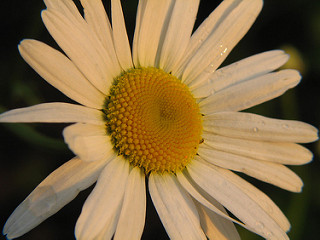

dandelion ：898张


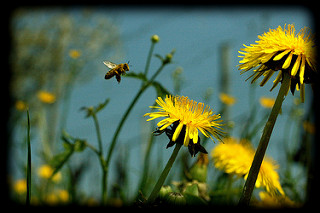

roses     ：641张


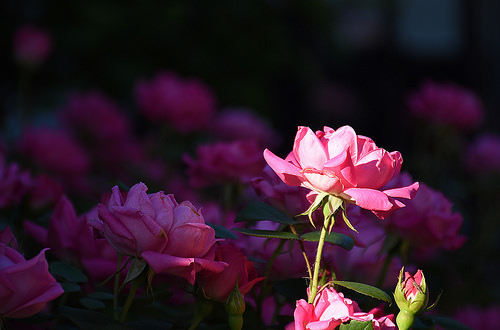

sunflowers：699张


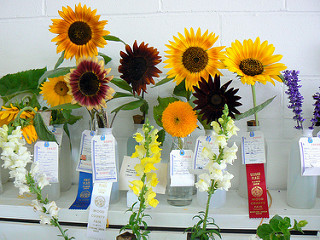

tulips    ：799张


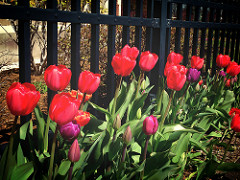

In [41]:
# 存储所有的图片的路径
ALL_FIG_PATH = []
# 存储所有的标签
ALL_LABEL = []
# 存储类别、编号的字典
start_calss_sign =0
class_dict = {}  # 类别、编号字典
class_list = []  # 类别列表
for item in data_root.iterdir():
    if pathlib.Path.is_dir(item):
        # 图片文件列表
        fig_list = list(item.iterdir())
        ALL_FIG_PATH += [str(fip) for fip in fig_list] # 路径格式变为字符串
        ALL_LABEL += [start_calss_sign] * len(fig_list)
        # 文件夹名称
        dir_name = item.name
        class_list.append(dir_name)
        class_dict[start_calss_sign] = dir_name
        start_calss_sign += 1
        # 图片个数
        print('{:10s}：{}张'.format(dir_name, len(fig_list)))
        # 显示图片
        for fig in np.random.choice(fig_list, 1):
            display.display(display.Image(fig))

### 2、图像数据转换

所有图片的路径ALL_FIG_PATH，对应的标签ALL_LABEL，标签和真实类别对应的字典class_dict。

In [4]:
# 将数据变为同样大小的，并且归一化
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])  # 统一大小
    image /= 255.0  # 归一化
    return image

In [5]:
# 根据路径读取图片数据
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

### 3、构建数据通道

首先分割数据集，将数据集合按照比例分为训练、验证以及测试数据集。

In [6]:
# 按比例分割数据集合：训练、非训练
X_train, X_no_train, Y_train, Y_no_train = train_test_split(ALL_FIG_PATH, ALL_LABEL, test_size=0.33, stratify=ALL_LABEL)  # 保持比例
# 将非训练分割为验证和测试
X_val, X_test, Y_val, Y_test = train_test_split(X_no_train, Y_no_train, test_size=0.33, stratify=Y_no_train)
# 训练图片的数量
fig_count = len(X_train)

将图片路径和图片的标签合并在一起，形成数据集形式

In [7]:
def get_dataset(figpath, figlabel):
    #  利用from_tensor_slices进行进行特征切片
    ds = tf.data.Dataset.from_tensor_slices((figpath, figlabel))
    # 路径变为图片
    def load_and_preprocess_from_path_label(path, label):
        return load_and_preprocess_image(path), label
    
    return ds.map(load_and_preprocess_from_path_label)

In [8]:
# 训练数据集
TRAIN_DATA = get_dataset(X_train, Y_train)
# 验证数据集
VAL_DATA = get_dataset(X_val, Y_val)
# 测试数据集
TEST_DATA = get_dataset(X_test, Y_test)

将训练数据进行随机转换，并将数据存储在缓存文件中，提升模型训练的效率。

In [9]:
BATCH_SIZE  = 64  # 批次训练的样本数
train_ds = TRAIN_DATA.cache(filename='./cache.tf-data')  # 定义缓存文件，提升运行效率
train_ds = train_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=fig_count))  # 随机打乱的缓冲定义为全部图片的个数，有助于打乱数据
train_ds = train_ds.batch(BATCH_SIZE).prefetch(1)  # 训练数据
val_ds = VAL_DATA.batch(BATCH_SIZE) # 验证数据

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


### 4、构建CNN模型

+ ### 4.1 模型建立

利用Sequential按层顺序创建CNN模型

In [48]:
### 建立模型
def build_cnn(name='CNN_V'):
    # 输入层
    in_put = tf.keras.Input(shape=(192, 192, 3), name='INPUT')
    
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', name='CONV_1')(in_put)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', name='CONV_2')(x)
    # 最大池化层
    x = tf.keras.layers.MaxPooling2D(pool_size=[2,2], name='MAXPOOL_1')(x)

    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_3')(x)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_4')(x)
    # 最大池化层
    x = tf.keras.layers.MaxPooling2D(pool_size=[2,2], name='MAXPOOL_2')(x)
    
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding='same', name='CONV_5')(x)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=[3,3], activation='relu', padding='same', name='CONV_6')(x)
    # 卷积层
    x = tf.keras.layers.Conv2D(filters=5, kernel_size=[1,1], activation='relu', padding='same', name='CONV_7')(x)

    # 全局平均池化层，和平铺层相比，有助于减少参数
    x = tf.keras.layers.GlobalAveragePooling2D(name='GAP_1')(x)
    
    # 输出层
    out_put = tf.keras.layers.Dense(5, activation='softmax', name='OUTPUT')(x)

    #  建立模型
    model = tf.keras.Model(inputs=in_put, outputs=out_put, name=name)
    # 模型编译
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# 建立模型
CNN_Model = build_cnn()

In [49]:
CNN_Model.summary()

Model: "CNN_V"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 192, 192, 3)]     0         
_________________________________________________________________
CONV_1 (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 188, 188, 64)      18496     
_________________________________________________________________
MAXPOOL_1 (MaxPooling2D)     (None, 94, 94, 64)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 94, 94, 64)        36928     
_________________________________________________________________
CONV_4 (Conv2D)              (None, 94, 94, 64)        36928     
_________________________________________________________________
MAXPOOL_2 (MaxPooling2D)     (None, 47, 47, 64)        0     

+ ### 4.2 模型训练

建立回调，保存最佳模型。

In [50]:
# 保存模型的文件夹
checkpoint_path_base = "./cnn_v-{val_accuracy:.5f}.ckpt"
checkpoint_dir_base = os.path.dirname(checkpoint_path_base)

# 创建一个回调，保证验证数据集损失最小
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_base, save_weights_only=True,
                                                    monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)

In [51]:
# 模型训练
model_history = CNN_Model.fit(train_ds, epochs=400, verbose=2, validation_data=val_ds, steps_per_epoch=10, callbacks=[model_callback])

Train for 10 steps, validate for 13 steps
Epoch 1/400

Epoch 00001: val_accuracy improved from -inf to 0.18842, saving model to ./cnn_v-0.18842.ckpt
10/10 - 133s - loss: 1.6109 - accuracy: 0.1953 - val_loss: 1.6081 - val_accuracy: 0.1884
Epoch 2/400

Epoch 00002: val_accuracy improved from 0.18842 to 0.24384, saving model to ./cnn_v-0.24384.ckpt
10/10 - 118s - loss: 1.6071 - accuracy: 0.2531 - val_loss: 1.6064 - val_accuracy: 0.2438
Epoch 3/400

Epoch 00003: val_accuracy improved from 0.24384 to 0.27833, saving model to ./cnn_v-0.27833.ckpt
10/10 - 118s - loss: 1.6020 - accuracy: 0.2500 - val_loss: 1.5851 - val_accuracy: 0.2783
Epoch 4/400

Epoch 00004: val_accuracy did not improve from 0.27833
10/10 - 119s - loss: 1.5711 - accuracy: 0.2875 - val_loss: 1.5511 - val_accuracy: 0.2549
Epoch 5/400

Epoch 00005: val_accuracy improved from 0.27833 to 0.33374, saving model to ./cnn_v-0.33374.ckpt
10/10 - 118s - loss: 1.5393 - accuracy: 0.2797 - val_loss: 1.5268 - val_accuracy: 0.3337
Epoch 6/

## 5、CNN可视化

加载最佳模型 

In [52]:
# 加载已经训练好的参数
model_best= build_cnn()
best_para_weight = tf.train.latest_checkpoint(checkpoint_dir_base)
model_best.load_weights(best_para_weight)

+ ### 5.1 可视化模型每层的输出

在测试数据中随机选择第一个图片，查看模型中的每一层针对此图片的输出。

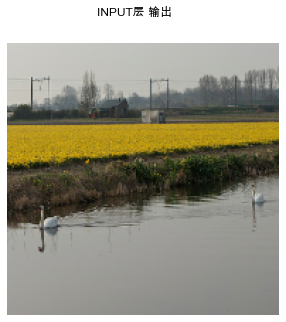

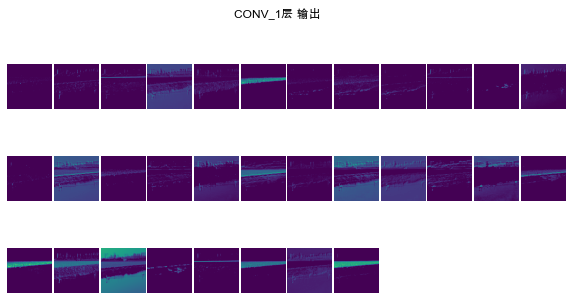

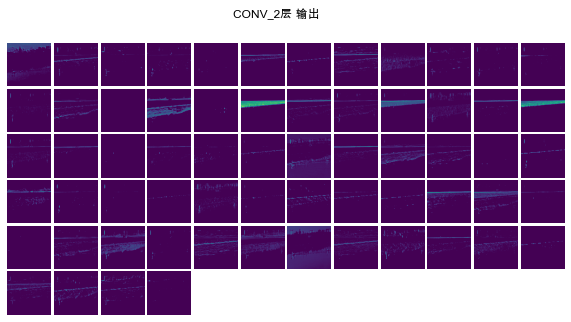

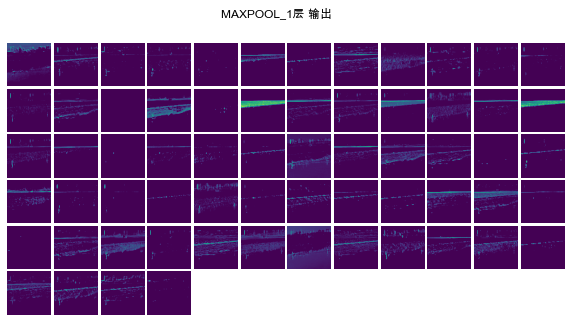

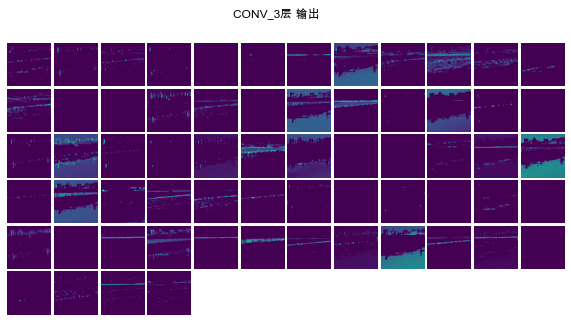

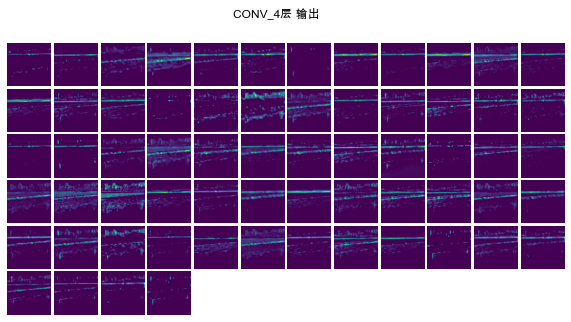

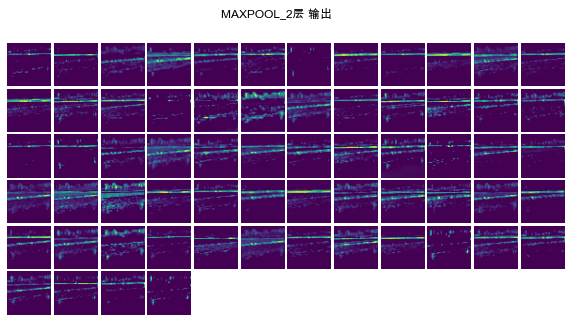

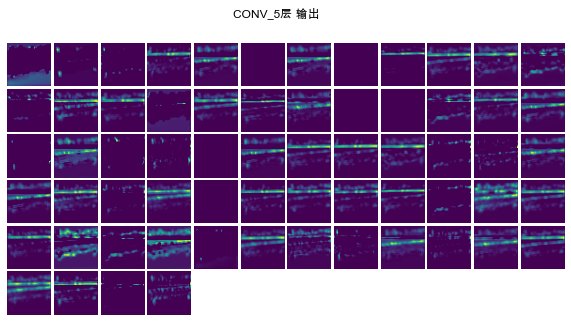

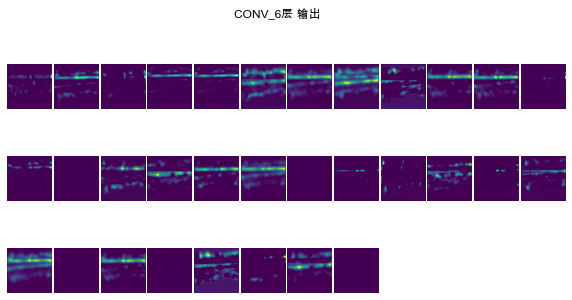

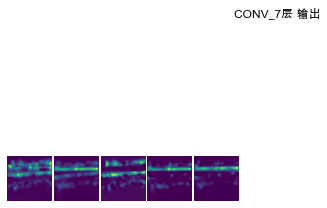

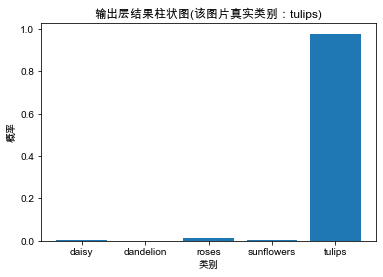

In [53]:
# 随机打乱
TEST_DATA = TEST_DATA.shuffle(400)
# 选择第一个
for d in TEST_DATA.take(1):
    x, label = d
    # 图片数据
    fig_data = x.numpy()
    # 图片对应的标签数据
    label_data = class_list[label.numpy()]
    # 添加维度
    add_fig_data = fig_data[None,:,:,:]
    # 模型预测结果
    result = model_best.predict(add_fig_data)
    # 模型预测类别
    predict_lable = class_list[np.argmax(result, axis=1)[0]]

    # 每一行图片的个数
    column = 12
    # 查看每一层的输出
    layer = model_best.layers  # 所有层
    for l in layer:  # 遍历层
        # 输出
        add_fig_data = l(add_fig_data)  
        # 绘制层的输出
        count = add_fig_data.shape[-1]
        # 去掉添加的维度
        s_data = tf.squeeze(add_fig_data)
        # 需要的行数
        row = ceil(count / column)
        if len(s_data.shape) == 3:  
            filer_data = tf.transpose(s_data, perm=[2, 0, 1])
            fig = plt.figure(figsize=(10, 5))
            sign = 1
            if filer_data.shape[0] == 3: # 原始图片，
                fig.add_subplot(1,1,sign)
                plt.axis('off')
                plt.imshow(s_data)
            else:
                for sd in filer_data:
                    fig.add_subplot(row,column,sign)
                    plt.axis('off')
                    plt.imshow(sd)
                    sign += 1
            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            plt.suptitle('{}层 输出'.format(l.name))
            plt.show()
    # 输出预测结果的各个类别的柱状图以及
    plt.figure()
    plt.bar(class_list, result[0])
    plt.title('输出层结果柱状图(该图片真实类别：{})'.format(label_data))
    plt.xlabel('类别')
    plt.ylabel('概率')
    plt.show()
        

+ ### 5.2 可视化每个卷积层学到的特征

可视化卷积层中的每个卷积核学到的特征，并不是待模型训练完毕后，将该卷积核展示出来，因为卷积核的高度和宽度一般都很小，直接展示出来作用不大，并不能清晰的看出学到的特征。一般有2种方式，一是利用反卷积，实现比较困难；二是下面利用梯度上升的思想来做，通过合成一个图片，使得该卷积核获得最大的激活值，经过一定次数的优化，最终这个图片就可认为是该卷积核学到的特征，步骤如下：
+ 给定训练好的模型一个随机噪声的初始图，将这张图作为模型的输入$x$，计算其在模型中第$i$层$j$个卷积核的激活值$A_{ij}(x)$，也就是输出值；
+ 计算梯度$$\frac{\delta A_{ij}(x)}{\delta x}$$做一个反向传播，也就是用该图的卷积核梯度来更新噪声图：$$x  += \eta \frac{\delta A_{ij}(x)}{\delta x}$$其中$\eta$为学习率；

以此通过改变每个像素的颜色值以增加对该卷积核的激活值。


将浮点类型的数据变为像素值，并平滑，便于图像的展示

In [54]:
# 将浮点值转换成像素值
def deprocess_image(x):
    # 对张量进行规范化
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    # 转化到RGB数组
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

 根据卷积层的层索引输出该层某卷积核学习到的特征

In [55]:
# 根据卷积层的层索引输出该层某卷积核学习到的特征
def get_filter(model, convsign, filtersign, initfig, times, lr):
    """
    model:训练好的模型
    convsign:模型中某个卷积层的索引
    filtersign: 卷积层的卷积核索引，不得大于该卷积层卷积核的个数
    initfig:初始化图片
    times:迭代的次数
    lr:类似学习率
    """
    # 开始迭代
    for i in range(1, times+1):
        # tensorflow2计算梯度的方式
        with tf.GradientTape(persistent=True) as gtape:
            # 加入变量
            gtape.watch(initfig)
            # 输入层
            middle_data = model.layers[0](initfig)
            # 正向传播
            for l in range(1, convsign+1):
                middle_data = model.layers[l](middle_data)
            # 获得该卷积核的损失
            loss = tf.math.reduce_mean(middle_data[:, :, :, filtersign])
        # 计算梯度
        grads  = gtape.gradient(loss, initfig)
        # 平滑梯度
        grads /= (tf.math.sqrt(tf.math.reduce_mean(tf.math.square(grads))) + 1e-5)
        # 更改图片
        initfig += grads * lr
    # 浮点类型转化为像素值
    return deprocess_image(initfig.numpy()[0])

输出某模型所有卷积层中所有卷积核学习到的特征

In [56]:
# 首先获取模型中所有卷积层：卷积层索引：[卷积层名称，卷积核个数]
def get_conv(model):
    layer_dict = dict([(sign, [layer.name, len(layer.get_weights()[1])]) 
                   for sign, layer in enumerate(model_best.layers) 
                   if isinstance(layer, tf.keras.layers.Conv2D)])
    return layer_dict

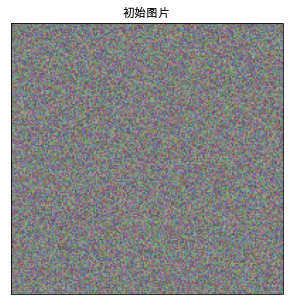

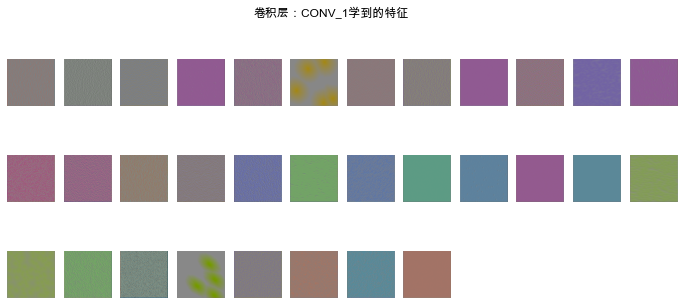

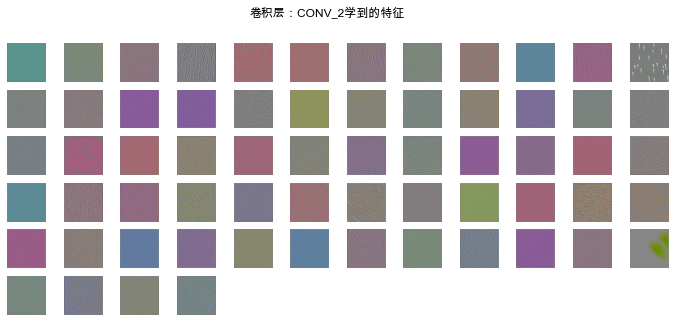

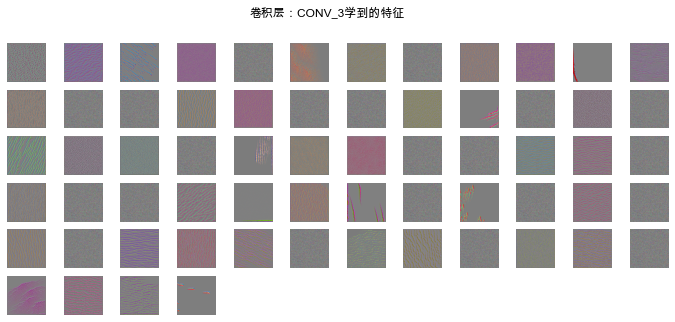

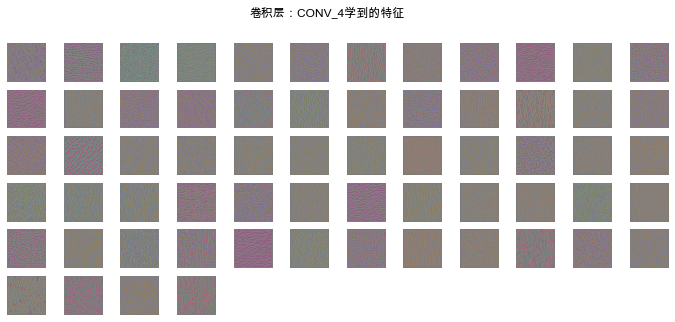

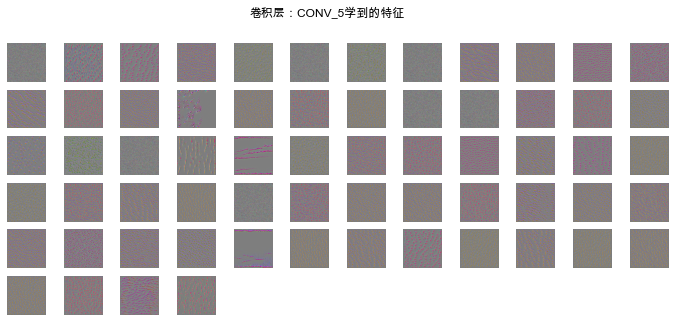

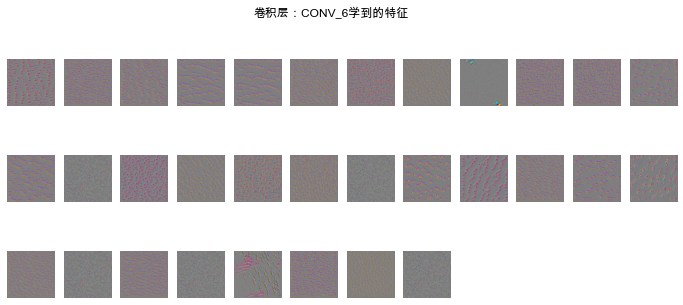

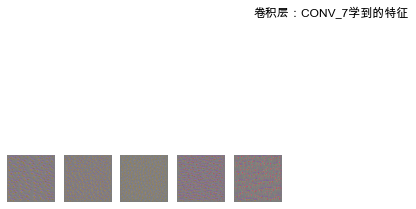

In [57]:
# 展示模型中所有的卷积层学到的特征
def show_conv(model, times=60, lr=0.7, column=12):
    layer_dict = get_conv(model)
    # 初始图片
    plt.figure(figsize=(5, 5))
    # 随机噪声数据
    fig_start = tf.constant(np.random.random((1, 192, 192, 3)))  # 维度需要和模型的一致
    plt.imshow(deprocess_image(fig_start.numpy()[0]))
    plt.xticks([])
    plt.yticks([])
    plt.title('初始图片')
    plt.show()

    # 遍历卷积层
    for c in layer_dict:
        # 图片
        fig = plt.figure(figsize=(12, 5))
        # 卷积核个数
        count = layer_dict[c][1]
        row =ceil(count/ column)
        for f in range(count):
            data = get_filter(model, c, f, fig_start, times, lr)
            fig.add_subplot(row, column, f+1)
            plt.axis('off')
            plt.imshow(data)
        plt.suptitle('卷积层：%s学到的特征' % layer_dict[c][0])
        plt.show()
        
show_conv(model_best)    

+ ### 5.3 类激活图可视化

  + **（1）类激活图（CAM， class activation map）**

类激活热力图是针对训练好的模型，输入属于某类的一个图片，输出的是这张图片中各个位置对于这个类的贡献程度的热力图。

实现CAM对模型结构是有要求的，也就是模型的倒数第二层必须是GAP层(GlobalAveragePooling，全局均值池化),并且该层的输出必须等于类别数，因为池化层的输出是根据前面的卷积层的卷积核的个数来的，所以这就要求前面的卷积核的个数为类别数。

下面以本文中的例子说一下如何实现CAM，首先看下面的图片：
 

上面图示模型中最后一个卷积层中浓缩了很多的特征信息，GAP层就可看作分类器，最后的结果就是分类器结合不同权重的线性叠加，所以CAM就是最后一个卷积层的输出和权重的线性叠加，转变成热力图，放大到和输入图片相同的尺寸，并和原始图片叠加在一起。下面给出本文中CAM的结果。

In [58]:
# 绘制CAM的函数
def show_am(fig_data, change_out, weights, pre_result, label, fig_sign, cl=class_list):
    # 首先获得卷积核的个数
    count = len(change_out)
    # 需要绘制的图片的个数
    count += 3
        
    index = 0
    # 判断概率最大值得索引
    max_index = tf.argmax(pre_result[0])
    # 获得对应的权重
    weight = weights[0][:, max_index]
    bias = weights[1][max_index]
    height, width, c = fig_data.shape
    
    plt.figure(figsize=(18, 9))
    
    # 原始图
    plt.subplot(1, count, 1)
    figdata = np.uint8(255 * fig_data)
    plt.imshow(figdata)
    plt.axis('off')
    plt.title('原始图片类别\n{}'.format(cl[max_index]))
    
    # 绘制卷积核的图
    for out in change_out:
        # 获取对应的权重
        plt.subplot(1, count, 2+index)
        plt.title('第%s个卷积核\n $%.5f \\times $' % (index+1, weight[index]))
        # 绘制热力图
        kk = out[:,:,None] 
        # 归一化【0，1】
        kk = tf.nn.relu(kk)
        kk /= np.max(kk)
        image = tf.image.resize(kk, [height, width])[:,:,0]
        image = np.uint8(255 * image)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        if index != 0:
            plt.ylabel('+',fontsize=19)
        index += 1
    
    # 绘制最终的热力图:现行叠加的
    plt.subplot(1, count, 2+index)
    last_data = tf.add(tf.math.reduce_sum(tf.multiply(change_out,weight[:,None,None]), axis=0), bias)
    last_data = last_data[:, :, None]
    last_data = tf.nn.relu(last_data)
    last_data /= np.max(last_data)
    image = tf.image.resize(last_data, [height, width])[:,:,0]
    image = np.uint8(255 * image)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('=',fontsize=19, verticalalignment='center',horizontalalignment='center',rotation='horizontal')
    plt.title('线性叠加的热力图\n偏置{:.5f}'.format(bias))
    
    # 绘制热力图和原始图片的叠加
    plt.subplot(1, count, 3+index)
    # 伪彩色
    heatmap = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    super_img = heatmap * 0.3 + figdata
    cv2.imwrite('cam.jpg', super_img)
    data = cv2.imread('cam.jpg')
    b,g,r=cv2.split(data)
    image=cv2.merge([r,g,b])
    plt.imshow(image)
    plt.axis('off')
    plt.title('CAM 预测类别\n%s' % (cl[max_index]))
    plt.savefig('cam_%s.png'% fig_sign, dpi=180, bbox_inches='tight')
    plt.show()

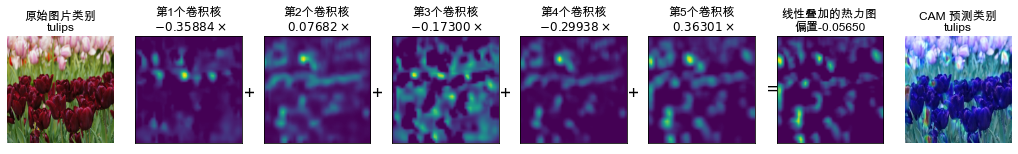

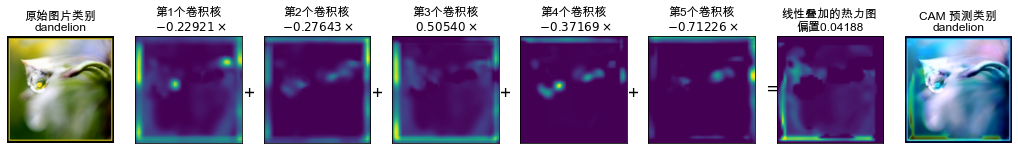

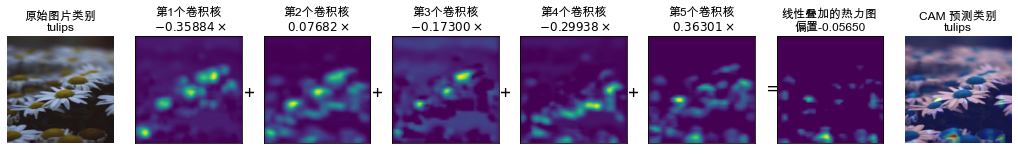

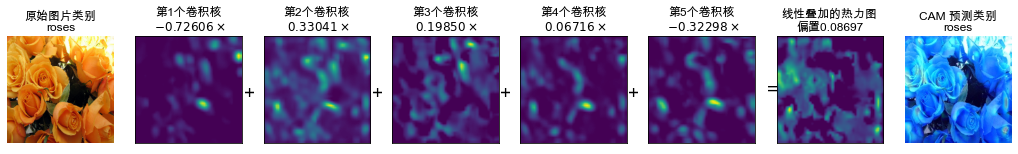

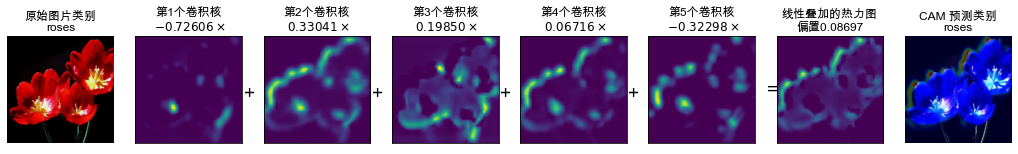

In [59]:
# 在测试数据集中随机选择n个图片，对GAP层前面的卷积层输出CAM
def get_am(model, data=TEST_DATA, conv_name='CONV_7', gap_name='GAP_1', out_name='OUTPUT', n=10):
    fig_sign = 0
    # 模型
    conv_layer = model.get_layer(conv_name) 
    gap_layer = model.get_layer(gap_name) 
    cam_model =models.Model([model.inputs], [conv_layer.output, gap_layer.output, model.output])
    # 遍历图片
    for d in data.take(n):
        # 数据，标签
        x, label = d
        # 图片数据
        fig_data = x.numpy()
        # 添加维度
        add_fig_data = np.expand_dims(fig_data, axis=0)
        # 卷积层输出、预测结果
        conv_out, gap_out, pre_result = cam_model(add_fig_data)
        # 变换维度
        change_out = tf.transpose(conv_out[0], perm=[2, 0, 1])
        # 获取最后全连接层的参数
        weights = model.get_layer(out_name).weights
        
        # 显示CAM:图片数据、最后卷积层的输出、模型预测结果、图片标签、保存图片的名称
        show_am(fig_data, change_out, weights, pre_result, label, fig_sign)
        
        fig_sign += 1

get_am(model_best, n=5)    


  + **(2)加权梯度类激活图（Grad-CAM）**
    

如果训练好的模型的结构不符合要求，则可以利用Grad-CAM的方法去实现，避免了修改模型结构，再次进行训练的麻烦。 Grad-CAM的原理就是给出一张图片，得到模型针对该图片的预测概率的最大值，并计算该值针对卷积层输出的梯度，并计算梯度的均值，将梯度均值与对应的每个卷积核的输出相乘，求和然后计算均值，得到类激活图。

随机在测试数据集中选取用于展示的n张图片，分别针对每个图片输出卷积层的类激活图。

In [60]:
# 绘制grad_cam和原始图片数据的函数
def show_grad_cam(figdata, cam_data, conv_name, figname, savefigname, class_sign, cl=class_list):
    # 首先获取原始数据的维度
    height, width, c = figdata.shape
    # 将热力图数据也变为同样的维度：先保存为图片，在更改维度
    kk = cam_data[0][:,:,None] 
    image = tf.image.resize(kk, [height, width])[:,:,0]

    # 绘制图像：原始图片
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 3, 1)
    figdata = np.uint8(255 * figdata)
    plt.imshow(figdata)
    plt.axis('off')
    plt.title('原始图片类别\n{}'.format(cl[figname]))
    
    # 热力图
    plt.subplot(1, 3, 2)
    image = np.uint8(255 * image)
    plt.imshow(image)
    plt.axis('off')
    plt.title('层{}热力图'.format(conv_name))

    # 叠加
    plt.subplot(1, 3, 3)
    # 伪彩色
    heatmap = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + figdata
    cv2.imwrite('elephant_cam.jpg', superimposed_img)
    data = cv2.imread('elephant_cam.jpg')
    b,g,r=cv2.split(data)
    image=cv2.merge([r,g,b])
    plt.imshow(image)
    plt.axis('off')
    plt.title('GRAD_CAM 预测类别\n%s' % (cl[class_sign]))
      
    plt.savefig('grad_cam_%s.png'% savefigname, dpi=100, bbox_inches='tight')
    plt.show() 
    

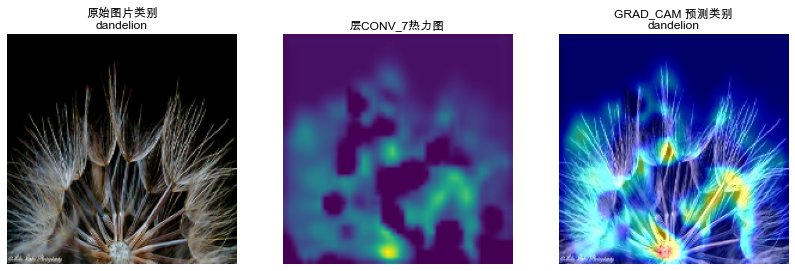

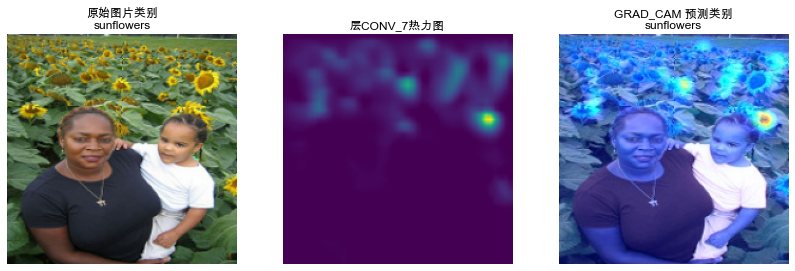

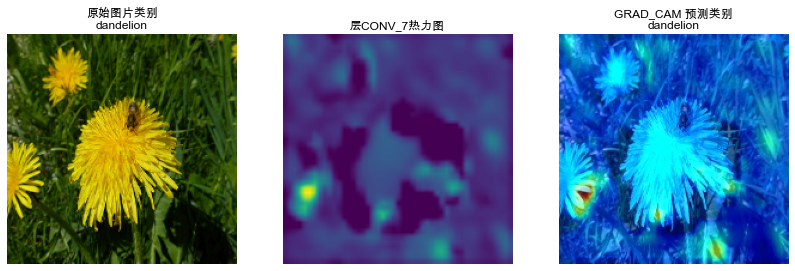

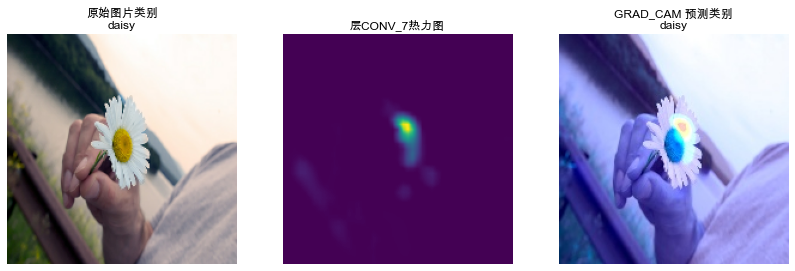

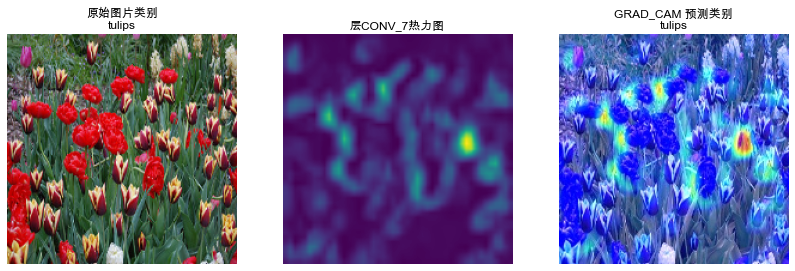

Grad-CAM运行结束


In [64]:
# 测试数据集中随机选择n张
def get_grad_cam(model, data=TEST_DATA, conv_name=None, n=5):
    """
    model:训练好的模型
    data:测试数据集
    conv_name:默认为最后一个卷积层。注意卷积层名字要正确
    n:随机选择的图片个数
    """
    # 获取所有的卷积层
    conv_layer = get_conv(model)
    # 默认为最后一个卷积层
    if not conv_name:
        conv_name = model.get_layer(sorted(conv_layer.items(), key= lambda s:s[0])[-1][1][0])
    else:
        conv_name = model.get_layer(conv_name)
        
    # 定义计算热力图的模型
    heatmap_model =models.Model([model.inputs], [conv_name.output, model.output])
    # 随机选择一张图片
    fig_sign = 0
    for d in data.take(n):
        # 数据，标签
        x, label = d
        # 图片数据
        fig_data = x.numpy()
        # 添加维度
        add_fig_data = np.expand_dims(fig_data, axis=0)
        
        # 计算梯度
        with tf.GradientTape() as gtape:
            # 卷积层的输出，以及模型针对该图片的输出
            conv_output, pre_result = heatmap_model(add_fig_data)
            # 选择模型的预测值，也就是概率较大的
            class_sign = tf.math.argmax(pre_result[0])
            prob = pre_result[:, class_sign]  
            # 计算概率值对于卷积层输出的梯度
            grads = gtape.gradient(prob, conv_output) 
            # 计算梯度的均值
            pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))  
        # 输出乘以该卷积核的平均梯度 加在一起计算均值    
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
        # 选择值不小于0的
        heatmap = tf.nn.relu(heatmap)
        # 归一化【0，1】
        heatmap /= np.max(heatmap)
        # 图像的展示：图片数据、热力图、卷积层名称、图片标签、保存图片名称、概率结果中最大值索引
        show_grad_cam(fig_data, heatmap, conv_name.name, label, fig_sign, class_sign)
        fig_sign += 1
    return print('Grad-CAM运行结束')

get_grad_cam(model_best, conv_name='CONV_7')